#Getting Started..

The data we'll be handling with in this notebook is 'vehicles.csv'.

It contains various columns named manufacturer, model, condition, fuel, odometer, paint_color etc.., representing the features of the vehicle along with	'price' column which represents the price of the vehicle.

####Importing Essential libraries

In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


####Importing Data

In [ ]:
#Importing Data
df=pd.read_csv('/content/drive/MyDrive/AI ML DL/Project/Vehicles.csv')

#changing the datatype of year column values from object to integer
df['year']=df['year'].astype('int64')
#dropping lat,long and id columns as we working with them for now
df.drop(['lat','long','id'],axis=1, inplace=True)
df.head(5)

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,price
0,mohave county,2012,jeep,patriot,like new,4 cylinders,gas,247071.0,clean,automatic,4wd,full-size,offroad,silver,3495
1,oregon coast,2014,bmw,328i m-sport,good,5 cylinders,gas,76237.0,clean,automatic,rwd,full-size,sedan,grey,13750
2,greenville / upstate,2001,dodge,caravan,excellent,6 cylinders,gas,199000.0,clean,automatic,4wd,full-size,offroad,grey,2300
3,mohave county,2004,chevrolet,colorado ls,excellent,5 cylinders,gas,54000.0,clean,automatic,rwd,mid-size,pickup,red,9000
4,maine,2005,ford,mustang convertible,excellent,6 cylinders,gas,62800.0,clean,automatic,rwd,mid-size,convertible,silver,8500


In [ ]:
print(df.shape,df.columns)

(374222, 15) Index(['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'price'],
      dtype='object')


# Exploratory Data Analysis
In this section we plot different plots between variables both independent and dependent to understand the trends, patterns between them and draw meaningful insights from the dataset. 

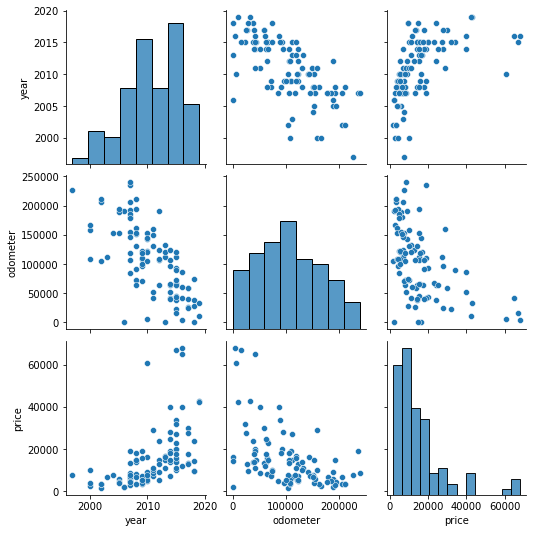

,year,odometer,price
year,1.000000,-0.623788,0.533806
odometer,-0.623788,1.000000,-0.484654
price,0.533806,-0.484654,1.000000


In [ ]:
#using pairplot and correlation matrix to find correlation between independent variables
df2=df.sample(100)
sns.pairplot(df2)
plt.show()
df.corr()

From the above plots and correlation matrix we can say that year and price columns are moderately correlated with each other and negatively correlated with odometer column, but there is no presence of high correlation between the features.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


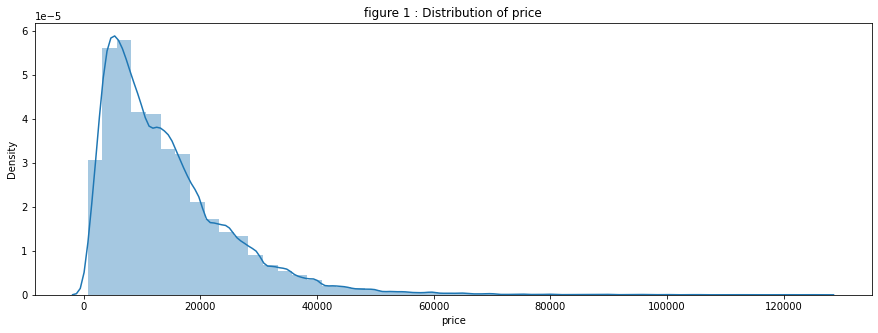

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(df.price)
plt.title("figure 1 : Distribution of price")
plt.show()

From the above plot we can infer that the price isn't normally distributed across the dataset, and the price increased rapidly initially upto a certain point and then decreased.

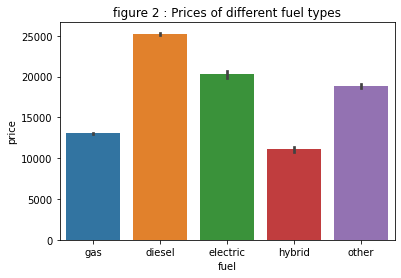

In [ ]:
sns.barplot(x='fuel',y='price',data=df)
plt.title('figure 2 : Prices of different fuel types')
plt.show()

From the above plot we can infer that prices of diesel varient vehicles is more than remaining varients of vehicles, in which hybrid varient occupies the last position with lowest prices.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


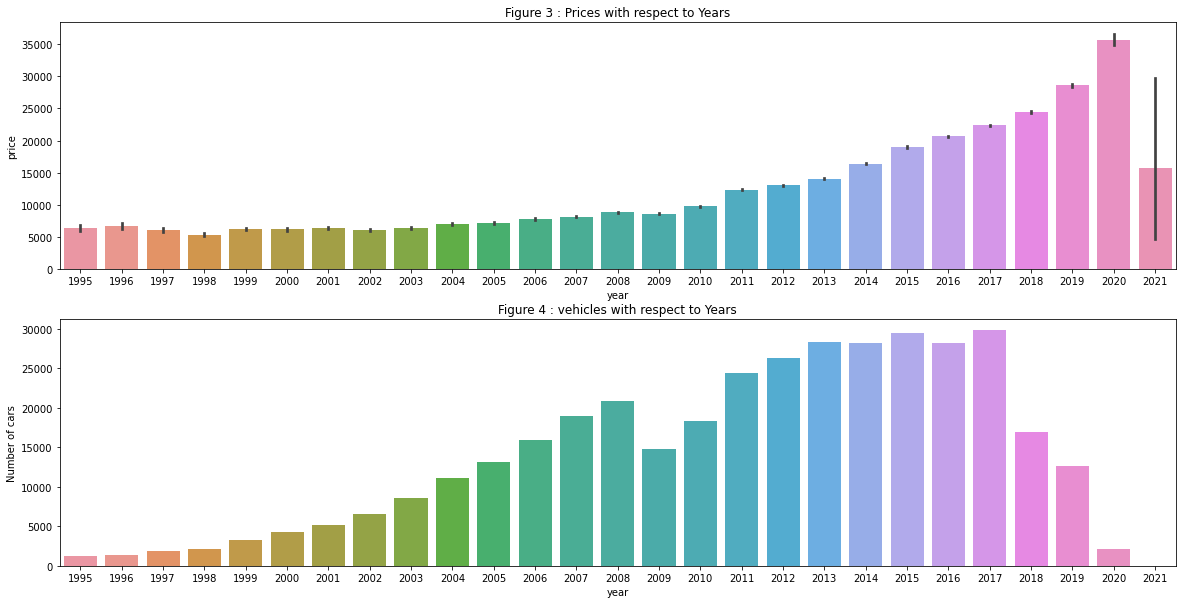

In [ ]:
fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(20,10)
sns.barplot(x='year',y='price',data=df,ax=axs[0])
sns.barplot(df.groupby('year').count()['price'].index,df.groupby('year').count()['price'].values,ax=axs[1])
axs[0].set_title('Figure 3 : Prices with respect to Years')
axs[1].set_title('Figure 4 : vehicles with respect to Years')
axs[1].set_ylabel('Number of cars')
#plt.tight_layout()
plt.show()

From the above plots we can analyze that car prices are increasing per year after 1995 (According to figure 3), also that number of cars are increasing per year(According to figure 4).

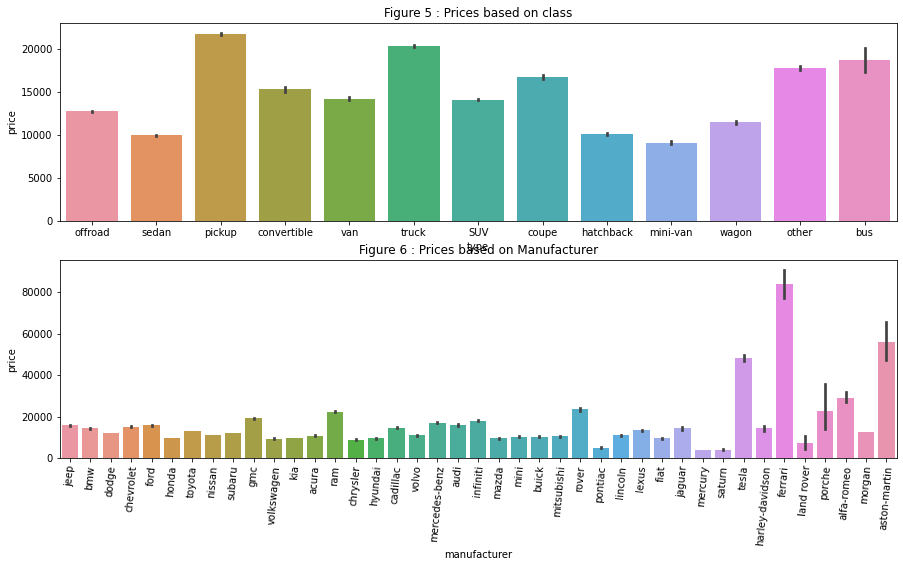

In [ ]:
fig,axs=plt.subplots(nrows=2)
fig.set_size_inches(15,8)
sns.barplot(x='type',y='price',data=df,ax=axs[0])
sns.barplot(x='manufacturer',y='price',data=df,ax=axs[1])
axs[1].set_xticklabels(df.manufacturer.unique(),rotation=85)
axs[0].set_title('Figure 5 : Prices based on class')
axs[1].set_title('Figure 6 : Prices based on Manufacturer')
plt.show()

From above plots we can infer that pickup vehicles are highest priced and minivans are lowest priced when compared to other class vehicles (According to figure 5).

We can also infer that Ferrari vehicles are highest priced and Mercury vehicles are lowest priced when compared to other brand vehicles (According to figure 6).

#Model Building
In this section, we shall consider different Machine Learning Models for training and validating on the dataset, and finally select the best model suitable for the data based on the model's accuracy.

Firstly, we should deal with the non-numerical datapoints in the dataset as we can't feed them to the machine learning model. We shall use the LabelEncoder from scikit.compose module to transform them then split our dataset into training and validating datasets. 

In [ ]:
le=LabelEncoder()

#Transforming the categorical data entries tonumerical entries
cat_cols=['region','manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color']
df[cat_cols]=df[cat_cols].apply(le.fit_transform)

#Splitting the dataset for training and validating the model
x=df.drop('price', axis=1)
y=df.price
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)

1. Linear Regression

Before training our models we have to scale the data so that we could reduce the computing time and get the most out of our model. Scaling the data makes it easy for the model to understand and analyse the relations between independent and dependent variables in our dataset.


For achieving this we create a pipeline. 'Pipeline()' consists of steps which indicates the processes that are performed on the data before feeding it to model, for more details You can refer to it's documentation, here we'll be creating our own custom pipeline using 'make_pipeline()'. We'll be also using 'TransformedTargetRegressor()', the main purpose of it is to scale the target variable before feeding it to the model and then transform back the target variable after predicting to original scale when used '.predict()'

In [ ]:
#Creating a pipeline so that data can be scaled before feeding it to the model
pipeline=make_pipeline(StandardScaler(), LinearRegression())
model=TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

#Initializing the model and training it
model.fit(x_train,y_train)

#Making predictions and calculating score of the model
y_pred=model.predict(x_test)
score=r2_score(y_test,y_pred)

#Storing the score of the model in a dataframe
data={'Model': 'Linear Regression', 'Accuracy': score*100}
Accuracy = pd.DataFrame(data, index=[1])
Accuracy

,Model,Accuracy
1,Linear Regression,47.822495


2. Lasso Regression

In [ ]:
pipeline=make_pipeline(StandardScaler(), Lasso(alpha=0.00001))
model=TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

model.fit(x_train,y_train)
y_pred=model.predict(x_test)
score=r2_score(y_test,y_pred)

data={'Model': 'Lasso Regression', 'Accuracy': score*100}
Accuracy = Accuracy.append(data, ignore_index=True)
Accuracy

,Model,Accuracy
0,Linear Regression,47.822495
1,Lasso Regression,47.822555


3. Ridge Regression

In [ ]:
pipeline=make_pipeline(StandardScaler(), Ridge(alpha=20))
model=TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

model.fit(x_train,y_train)
y_pred=model.predict(x_test)
score=r2_score(y_test,y_pred)

data={'Model': 'Ridge Regression', 'Accuracy': score*100}
Accuracy = Accuracy.append(data, ignore_index=True)
Accuracy


,Model,Accuracy
0,Linear Regression,47.822495
1,Lasso Regression,47.822555
2,Ridge Regression,47.822506


4. Random Forest Regressor

In [ ]:
pipeline=make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=180, random_state=0, max_features=0.5, n_jobs=-1))
model=TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

model.fit(x_train,y_train)
y_pred=model.predict(x_test)
score=r2_score(y_test,y_pred)

data={'Model': 'Random Forest Regression', 'Accuracy': score*100}
Accuracy = Accuracy.append(data, ignore_index=True)
Accuracy


,Model,Accuracy
0,Linear Regression,47.822495
1,Lasso Regression,47.822555
2,Ridge Regression,47.822506
3,Random Forest Regression,87.626672


5. K Nearest Neighbors


In [ ]:
pipeline=make_pipeline(StandardScaler(), KNeighborsRegressor())
model=TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

model.fit(x_train,y_train)
y_pred=model.predict(x_test)
score=r2_score(y_test,y_pred)

data={'Model': 'K Nearest Neighbors', 'Accuracy': score*100}
Accuracy = Accuracy.append(data, ignore_index=True)
Accuracy


,Model,Accuracy
0,Linear Regression,47.822495
1,Lasso Regression,47.822555
2,Ridge Regression,47.822506
3,Random Forest Regression,87.626672
4,K Nearest Neighbors,74.126551


6. Decision Tree Regressor

In [ ]:
pipeline=make_pipeline(StandardScaler(), DecisionTreeRegressor())
model=TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

model.fit(x_train,y_train)
y_pred=model.predict(x_test)
score=r2_score(y_test,y_pred)

data={'Model': 'DecisionTreeRegressor', 'Accuracy': score*100}
Accuracy = Accuracy.append(data, ignore_index=True)
Accuracy

,Model,Accuracy
0,Linear Regression,47.822495
1,Lasso Regression,47.822555
2,Ridge Regression,47.822506
3,Random Forest Regression,87.626672
4,K Nearest Neighbors,74.126551
5,DecisionTreeRegressor,74.829955


7. XGBoost

XGBoost is not sensitive to monotonic transformations of its features for the same reason that decision trees and random forests are not, the model only needs to pick "cut points" on features to split a node. Splits are not sensitive to monotonic transformations: defining a split on one scale has a corresponding split on the transformed scale. so we can feed non-scaled data to the model.

In [ ]:
model=XGBRegressor(n_estimators=5000, learning_rate=0.05, n_jobs=-1)
model.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_test, y_test)], verbose=False)
y_pred=model.predict(x_test)
score=r2_score(y_test,y_pred)
print(score)


[14:44:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8208492929109827


In [ ]:
data={'Model': 'XGBRegressor', 'Accuracy': score*100}
Accuracy = Accuracy.append(data, ignore_index=True)
Accuracy


,Model,Accuracy
0,Linear Regression,47.822495
1,Lasso Regression,47.822555
2,Ridge Regression,47.822506
3,Random Forest Regression,87.626672
4,K Nearest Neighbors,74.126551
5,DecisionTreeRegressor,74.829955
6,XGBRegressor,82.084929


#Conclusion 

Let's plot the accuracies of all the models

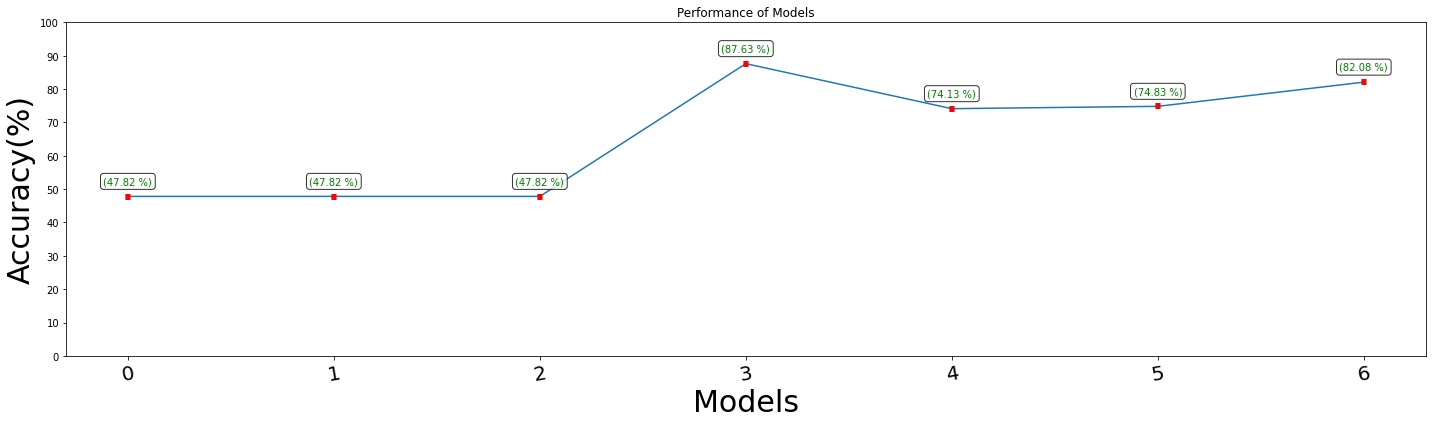

In [ ]:
model_accuracy=list(Accuracy.iloc[:,1])
x=list(range(len(model_accuracy)))
y=list(range(0,101,10))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(model_accuracy)
plt.yticks(y)
plt.xticks(fontsize=20)
plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=30)
plt.ylabel("Accuracy(%)",fontsize=30)
plt.title("Performance of Models")
for a,b in zip(x,y):
    b=model_accuracy[a]
    val="("+str(round(model_accuracy[a],2))+" %)"
    plt.text(a, b+4.5, val,horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
    plt.text(a, b+3.5, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)
plt.tight_layout()
plt.show()

Based on the above graph, we can say that both Random Forest Regressor and XGBRegressor with their current hyperparameters are the most feasible models for our dataset with more than 80% Accuracy. Let's compare the predictions of these both models before concluding the project.

Text(0.5, 1.0, 'Performance of Random Forest Regressor')

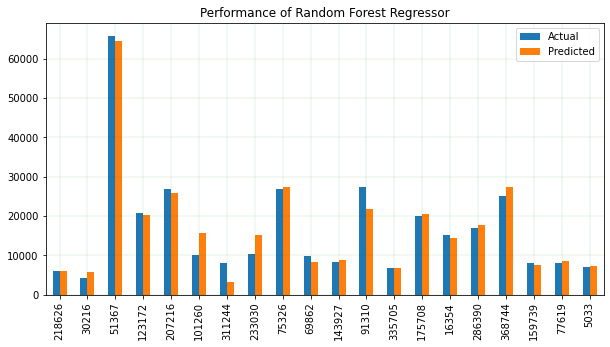

In [ ]:
pipeline=make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=180, random_state=0, max_features=0.5, n_jobs=-1))
model=TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

model.fit(x_train,y_train)
y_pred_1=model.predict(x_test)

df_check = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_1})
df_check = df_check.sample(20)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='Green')
plt.title('Performance of Random Forest Regressor')

[15:42:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0.5, 1.0, 'Performance of XGBRegressor')

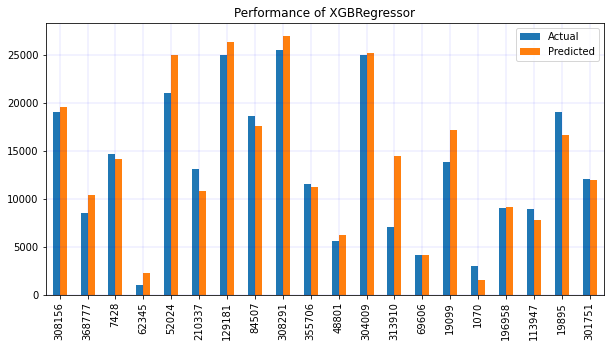

In [ ]:
model=XGBRegressor(n_estimators=5000, learning_rate=0.05, n_jobs=-1)
model.fit(x_train, y_train, early_stopping_rounds=10, eval_set=[(x_test, y_test)], verbose=False)
y_pred=model.predict(x_test)

df_check = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_check = df_check.sample(20)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='Blue')
plt.title('Performance of XGBRegressor')